<a href="https://colab.research.google.com/github/hoch881229/Learning-TF2/blob/master/People_Counter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Introduction<br>

**TO BE UPDATED!**

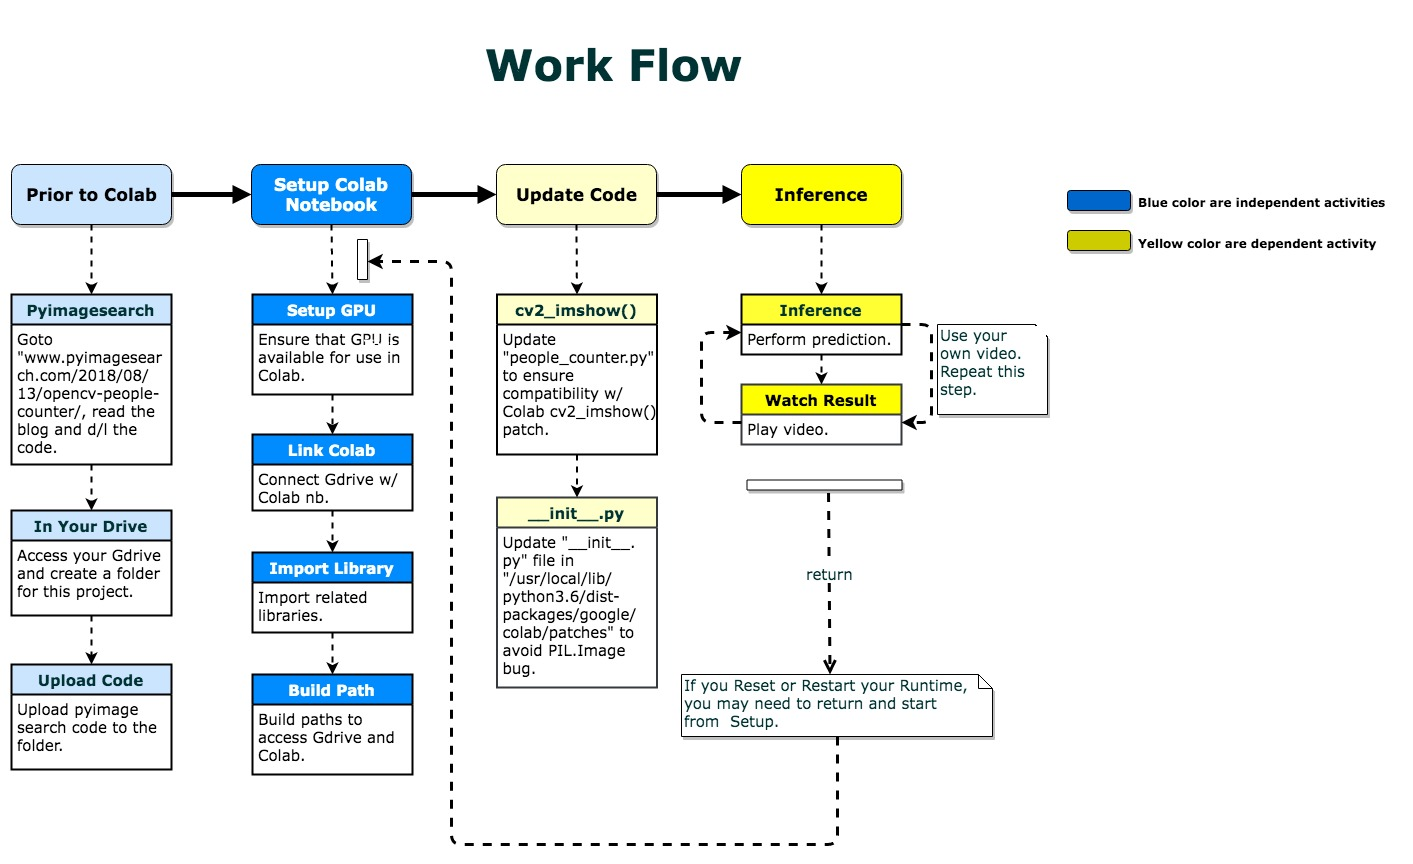

In [0]:
from IPython.display import Image as Img
Img('/content/gdrive/My Drive/start/github/Tutorials/People_Counter/People_Counter_Diagram.jpg', width = 1000, height = 600)

##Setup GPU<br>
* To implement the code for inference, we won't need access to GPU.  However, I am showing it here so you know how to access the GPU when need it.

In [1]:
#' ' means CPU whereas '/device:G:0' means GPU
import tensorflow as tf
tf.test.gpu_device_name()

# Note: If you see errors like "shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not 
#  connected", pls Restart your runtime.

'/device:GPU:0'

In [2]:
# Memory capacity.
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=bd61c37869972ef35a5f85a8676107b62fc2f9dfbdeebc908f850e162aa4f7d2
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.6 GB  | Proc size: 449.9 MB
GPU RAM Free: 11372MB | Used: 69MB | Util   1% | Total 11441MB


##Link Colab to Your Gdrive<br>

In [0]:
# Import libraries to mount Gdrive.
from pathlib import Path
from google.colab import drive

In [4]:
# Mount gdrive.  Run this cell, go to URL and authorize the access to your Gdrive.  Follow the instructions, copy the password and paste
# the password below.
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


##Import Library<br>

In [5]:
# Verify if required Python libraries are installed.
import numpy as np
import cv2
import dlib
import imutils
import PIL

print(f'Numpy v{np.__version__}')
print(f'OpenCV v{cv2.__version__}')
print(f'dlib v{dlib.__version__}')
print(f'imutils v{imutils.__version__}')
print(f'PIL v{PIL.__version__}')

Numpy v1.16.5
OpenCV v3.4.3
dlib v19.16.0
imutils v0.5.3
PIL v4.3.0


##Build Path<br>

In [0]:
# Setup paths to Gdrive(note: set your paths, it probably would differ from mines).
root_dir = Path('/content/gdrive/My Drive')
base_dir = root_dir.joinpath('start', 'github', 'Tutorials')
pyimgsrch_dir = base_dir.joinpath('People_Counter', 'Pyimagesearch-source_code')

video_dir = base_dir.joinpath('People_Counter', 'video')
ppl_count_dir =base_dir.joinpath('People_Counter')

# Setup paths to Colab.
colab_dir = Path('/content')

In [7]:
# Ensure that each paths has been properly created.
Path.ls = lambda x: list(x.iterdir())
pyimgsrch_dir.ls()
#video_dir.ls()
#ppl_count_dir.ls()
#colab_dir.ls()

[PosixPath('/content/gdrive/My Drive/start/github/Tutorials/People_Counter/Pyimagesearch-source_code/output'),
 PosixPath('/content/gdrive/My Drive/start/github/Tutorials/People_Counter/Pyimagesearch-source_code/videos'),
 PosixPath('/content/gdrive/My Drive/start/github/Tutorials/People_Counter/Pyimagesearch-source_code/mobilenet_ssd'),
 PosixPath('/content/gdrive/My Drive/start/github/Tutorials/People_Counter/Pyimagesearch-source_code/pyimagesearch'),
 PosixPath('/content/gdrive/My Drive/start/github/Tutorials/People_Counter/Pyimagesearch-source_code/people_counter.py'),
 PosixPath('/content/gdrive/My Drive/start/github/Tutorials/People_Counter/Pyimagesearch-source_code/.ipynb_checkpoints'),
 PosixPath('/content/gdrive/My Drive/start/github/Tutorials/People_Counter/Pyimagesearch-source_code/people_counter_v2.py'),
 PosixPath('/content/gdrive/My Drive/start/github/Tutorials/People_Counter/Pyimagesearch-source_code/people_counter_v3.py'),
 PosixPath('/content/gdrive/My Drive/start/gith

##cv2_imshow() patch<br>


> * Due to OpenCV compatibility issues with Colab(https://github.com/jupyter/notebook/issues/3935), we are unable to use OpenCV's "cv2.imshow()" method.<br>

> * Colab has created a patch to solve the above incompatility and we should use instead: "from google.colab.patches import cv2_imshow".<br>

> * We will have to update or change codes in 2 files: "people_counter.py" and dunder "init.py".  We will do all the changes in Colab.<br> 

###Updating "people_counter.py".<br>

In [9]:
# Change dir where "people_counter.py" is located.
%cd {pyimgsrch_dir}
!ls

/content/gdrive/My Drive/start/github/Tutorials/People_Counter/Pyimagesearch-source_code
mobilenet_ssd	   people_counter_v1.py  people_counter_v4.py
output		   people_counter_v2.py  pyimagesearch
people_counter.py  people_counter_v3.py  videos


* **We will update "people_counter.py" code. The new version will be called "people_counter_v1.py".**<br>

*  **Run the next cell, a script will pop up at the bottom of the screen.  Copy the codes from the screen and paste them into a new cell. Make the following changes:**<br>
> *Update_1: under "#import the necessary packages", add "from google.colab.patches import cv2_imshow".*<br>
> *Update_2: under "#show the output frame", change "cv2.imshow("Frame", frame)" to "cv2_imshow(frame)*"<br>

*  **After making the code update, at the top of the new cell, add "%%writefile people_counter_v1.py" and run the cell.**

In [0]:
%pycat people_counter.py

In [0]:
%%writefile people_counter_v1.py
# USAGE
# To read and write back out to video:
# python people_counter.py --prototxt mobilenet_ssd/MobileNetSSD_deploy.prototxt \
#       --model mobilenet_ssd/MobileNetSSD_deploy.caffemodel --input videos/example_01.mp4 \
#       --output output/output_01.avi
#
# To read from webcam and write back out to disk:
# python people_counter.py --prototxt mobilenet_ssd/MobileNetSSD_deploy.prototxt \
#       --model mobilenet_ssd/MobileNetSSD_deploy.caffemodel \
#       --output output/webcam_output.avi
# Update_1: add "from google.colab.patches import cv2_imshow"
# Update_2: change "cv2.imshow("Frame", frame)" to "cv2_imshow(frame)" 

# import the necessary packages
from pyimagesearch.centroidtracker import CentroidTracker
from pyimagesearch.trackableobject import TrackableObject
from imutils.video import VideoStream
from imutils.video import FPS
import numpy as np
import argparse
import imutils
import time
import dlib
import cv2
from google.colab.patches import cv2_imshow


# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-p", "--prototxt", required=True,
        help="path to Caffe 'deploy' prototxt file")
ap.add_argument("-m", "--model", required=True,
        help="path to Caffe pre-trained model")
ap.add_argument("-i", "--input", type=str,
        help="path to optional input video file")
ap.add_argument("-o", "--output", type=str,
        help="path to optional output video file")
ap.add_argument("-c", "--confidence", type=float, default=0.4,
        help="minimum probability to filter weak detections")
ap.add_argument("-s", "--skip-frames", type=int, default=30,
        help="# of skip frames between detections")
args = vars(ap.parse_args())

# initialize the list of class labels MobileNet SSD was trained to
# detect
CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
        "bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
        "dog", "horse", "motorbike", "person", "pottedplant", "sheep",
        "sofa", "train", "tvmonitor"]

# load our serialized model from disk
print("[INFO] loading model...")
net = cv2.dnn.readNetFromCaffe(args["prototxt"], args["model"])

# if a video path was not supplied, grab a reference to the webcam
if not args.get("input", False):
        print("[INFO] starting video stream...")
        vs = VideoStream(src=0).start()
        time.sleep(2.0)

# otherwise, grab a reference to the video file
else:
        print("[INFO] opening video file...")
        vs = cv2.VideoCapture(args["input"])

# initialize the video writer (we'll instantiate later if need be)
writer = None

# initialize the frame dimensions (we'll set them as soon as we read
# the first frame from the video)
W = None
H = None

# instantiate our centroid tracker, then initialize a list to store
# each of our dlib correlation trackers, followed by a dictionary to
# map each unique object ID to a TrackableObject
ct = CentroidTracker(maxDisappeared=40, maxDistance=50)
trackers = []
trackableObjects = {}

# initialize the total number of frames processed thus far, along
# with the total number of objects that have moved either up or down
totalFrames = 0
totalDown = 0
totalUp = 0

# start the frames per second throughput estimator
fps = FPS().start()

# loop over frames from the video stream
while True:
        # grab the next frame and handle if we are reading from either
        # VideoCapture or VideoStream
        frame = vs.read()
        frame = frame[1] if args.get("input", False) else frame

        # if we are viewing a video and we did not grab a frame then we
        # have reached the end of the video
        if args["input"] is not None and frame is None:
                break

        # resize the frame to have a maximum width of 500 pixels (the
        # less data we have, the faster we can process it), then convert
        # the frame from BGR to RGB for dlib
        frame = imutils.resize(frame, width=500)
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # if the frame dimensions are empty, set them
        if W is None or H is None:
                (H, W) = frame.shape[:2]

        # if we are supposed to be writing a video to disk, initialize
        # the writer
        if args["output"] is not None and writer is None:
                fourcc = cv2.VideoWriter_fourcc(*"MJPG")
                writer = cv2.VideoWriter(args["output"], fourcc, 30,
                        (W, H), True)

        # initialize the current status along with our list of bounding
        # box rectangles returned by either (1) our object detector or
        # (2) the correlation trackers
        status = "Waiting"
        rects = []

        # check to see if we should run a more computationally expensive
        # object detection method to aid our tracker
        if totalFrames % args["skip_frames"] == 0:
                # set the status and initialize our new set of object trackers
                status = "Detecting"
                trackers = []

                # convert the frame to a blob and pass the blob through the
                # network and obtain the detections
                blob = cv2.dnn.blobFromImage(frame, 0.007843, (W, H), 127.5)
                net.setInput(blob)
                detections = net.forward()

                # loop over the detections
                for i in np.arange(0, detections.shape[2]):
                        # extract the confidence (i.e., probability) associated
                        # with the prediction
                        confidence = detections[0, 0, i, 2]

                        # filter out weak detections by requiring a minimum
                        # confidence
                        if confidence > args["confidence"]:
                                # extract the index of the class label from the
                                # detections list
                                idx = int(detections[0, 0, i, 1])

                                # if the class label is not a person, ignore it
                                if CLASSES[idx] != "person":
                                        continue

                                # compute the (x, y)-coordinates of the bounding box
                                # for the object
                                box = detections[0, 0, i, 3:7] * np.array([W, H, W, H])
                                (startX, startY, endX, endY) = box.astype("int")

                                # construct a dlib rectangle object from the bounding
                                # box coordinates and then start the dlib correlation
                                # tracker
                                tracker = dlib.correlation_tracker()
                                rect = dlib.rectangle(startX, startY, endX, endY)
                                tracker.start_track(rgb, rect)

                                # add the tracker to our list of trackers so we can
                                # utilize it during skip frames
                                trackers.append(tracker)

        # otherwise, we should utilize our object *trackers* rather than
        # object *detectors* to obtain a higher frame processing throughput
        else:
                # loop over the trackers
                for tracker in trackers:
                        # set the status of our system to be 'tracking' rather
                        # than 'waiting' or 'detecting'
                        status = "Tracking"

                        # update the tracker and grab the updated position
                        tracker.update(rgb)
                        pos = tracker.get_position()

                        # unpack the position object
                        startX = int(pos.left())
                        startY = int(pos.top())
                        endX = int(pos.right())
                        endY = int(pos.bottom())

                        # add the bounding box coordinates to the rectangles list
                        rects.append((startX, startY, endX, endY))

        # draw a horizontal line in the center of the frame -- once an
        # object crosses this line we will determine whether they were
        # moving 'up' or 'down'
        cv2.line(frame, (0, H // 2), (W, H // 2), (0, 255, 255), 2)

        # use the centroid tracker to associate the (1) old object
        # centroids with (2) the newly computed object centroids
        objects = ct.update(rects)

        # loop over the tracked objects
        for (objectID, centroid) in objects.items():
                # check to see if a trackable object exists for the current
                # object ID
                to = trackableObjects.get(objectID, None)

                # if there is no existing trackable object, create one
                if to is None:
                        to = TrackableObject(objectID, centroid)

                # otherwise, there is a trackable object so we can utilize it
                # to determine direction
                else:
                        # the difference between the y-coordinate of the *current*
                        # centroid and the mean of *previous* centroids will tell
                        # us in which direction the object is moving (negative for
                        # 'up' and positive for 'down')
                        y = [c[1] for c in to.centroids]
                        direction = centroid[1] - np.mean(y)
                        to.centroids.append(centroid)

                        # check to see if the object has been counted or not
                        if not to.counted:
                                # if the direction is negative (indicating the object
                                # is moving up) AND the centroid is above the center
                                # line, count the object
                                if direction < 0 and centroid[1] < H // 2:
                                        totalUp += 1
                                        to.counted = True

                                # if the direction is positive (indicating the object
                                # is moving down) AND the centroid is below the
                                # center line, count the object
                                elif direction > 0 and centroid[1] > H // 2:
                                        totalDown += 1
                                        to.counted = True

                # store the trackable object in our dictionary
                trackableObjects[objectID] = to

                # draw both the ID of the object and the centroid of the
                # object on the output frame
                text = "ID {}".format(objectID)
                cv2.putText(frame, text, (centroid[0] - 10, centroid[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                cv2.circle(frame, (centroid[0], centroid[1]), 4, (0, 255, 0), -1)

        # construct a tuple of information we will be displaying on the
        # frame
        info = [
                ("Up", totalUp),
                ("Down", totalDown),
                ("Status", status),
        ]

        # loop over the info tuples and draw them on our frame
        for (i, (k, v)) in enumerate(info):
                text = "{}: {}".format(k, v)
                cv2.putText(frame, text, (10, H - ((i * 20) + 20)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

        # check to see if we should write the frame to disk
        if writer is not None:
                writer.write(frame)

        # show the output frame
        cv2_imshow(frame)
        key = cv2.waitKey(1) & 0xFF

        # if the `q` key was pressed, break from the loop
        if key == ord("q"):
                break

        # increment the total number of frames processed thus far and
        # then update the FPS counter
        totalFrames += 1
        fps.update()

# stop the timer and display FPS information
fps.stop()
print("[INFO] elapsed time: {:.2f}".format(fps.elapsed()))
print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

# check to see if we need to release the video writer pointer
if writer is not None:
        writer.release()

# if we are not using a video file, stop the camera video stream
if not args.get("input", False):
        vs.stop()

# otherwise, release the video file pointer
else:
        vs.release()

# close any open windows
cv2.destroyAllWindows()

Writing people_counter_v1.py


In [0]:
# Verify if the new file has been created. You can use "%pycat" command to check if the code change were made properly.
# Sometimes it may take a bit longer for the new file to appear.
!ls

mobilenet_ssd	   people_counter_v1.py  people_counter_v4.py
output		   people_counter_v2.py  pyimagesearch
people_counter.py  people_counter_v3.py  videos


###Updating dunder "init.py" file<br> 
> * Next we will update the dunder init.py file located in: <br>
"/usr/local/lib/python3.6/dist-packages/google/colab/patches/"<br>



In [18]:
# Change to patches dir.
%cd /usr/local/lib/python3.6/dist-packages/google/colab/patches/
!ls

/usr/local/lib/python3.6/dist-packages/google/colab/patches
__init__.py  __pycache__


* **We will update dunder "__init__.py" file. The new version will have the same name, dunder "__init__.py".**<br>

*  **Run the next cell, copy the code that pops up at the bottom of the screen.  Paste it into a new cell and make the following changes to the code:**<br>
> *Update_1: in the 3rd line of the script, change "import PIL" to "from PIL import Image"*.<br>
> *Update_2: under "# cv2 stores colors as BGR; convert to RGB", change "display.display(PIL.Image.fromarray(a)" to "display.display(Image.fromarray(a)"*<br>

*  **After update, at the top of the new cell, add "%%writefile __init__.py".  Run the cell.**

In [0]:
%pycat __init__.py

In [20]:
%%writefile __init__.py
import cv2
from IPython import display
from PIL import Image


def cv2_imshow(a):
  """A replacement for cv2.imshow() for use in Jupyter notebooks.

  Args:
    a : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
      (N, M, 3) is an NxM BGR color image. shape (N, M, 4) is an NxM BGRA color
      image.
  """
  a = a.clip(0, 255).astype('uint8')
  # cv2 stores colors as BGR; convert to RGB
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display.display(Image.fromarray(a))


cv_imshow = cv2_imshow

Overwriting __init__.py


In [23]:
# Verify if the new file has been created. You can use "%pycat" command to check if the code change were made properly.
# Sometimes it may take a bit longer for the new file to appear.
!ls

__init__.py  __pycache__


##Inference<br>

* We are almost ready for inference.  But before doing the prediction, we need to create a function to play the video inline.<br>

* Please also note that Colab only reads mp4 video format.  So, we will have to change the avi format video output used in Pyimagesearch to mp4 format.<br>

In [0]:
# play_mp4_video() will play video in mp4 format inline.

from IPython.display import clear_output, HTML
import io
import base64

def play_mp4_video(file_name, width=640, height=480):
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))
 


In [0]:
# The following command line converts avi video format to mp4 video format.
#!ffmpeg -y -loglevel info -i output/output_trial_6_1.avi output/output_trial_6_1.mp4

In [26]:
# Change to "Pyimagesearch-source_code" dir.
%cd {pyimgsrch_dir}
!ls

/content/gdrive/My Drive/start/github/Tutorials/People_Counter/Pyimagesearch-source_code
mobilenet_ssd	   people_counter_v1.py  people_counter_v4.py
output		   people_counter_v2.py  pyimagesearch
people_counter.py  people_counter_v3.py  videos


In [29]:
# Check video in videos dir.
!ls videos

example_01.mp4	video_trial_1.mp4  video_trial_3.mp4  video_trial_5.mp4
example_02.mp4	video_trial_2.mp4  video_trial_4.mp4  video_trial_6.mp4


In [30]:
# Check video in output dir.
!ls output 

output_01.avi	    output_trial_3.avi	  output_trial_5_1.avi
output_02.avi	    output_trial_3.mp4	  output_trial_5_1.mp4
output_03.avi	    output_trial_4_1.avi  output_trial_6_1_2.avi
output_03.mp4	    output_trial_4_1.mp4  output_trial_6_1.avi
output_trial_1.avi  output_trial_4_2.avi  output_trial_6_1.mp4
output_trial_1.mp4  output_trial_4_2.mp4  output_trial_6.avi
output_trial_2.avi  output_trial_4.avi	  output_trial_6.mp4
output_trial_2.mp4  output_trial_4.mp4


###Prediction<br>
* **Finally, prediction time!  Run the following cell to start the inference.**<br>
* **To perform inference in your custom video, add your video to videos dir and change "--input videos/<your_video.mp4> --ouput output/<your_video.avi>.**<br>  

In [0]:
# We run "people_counter_v1.py" to perform inference or prediction.
!python people_counter.py --prototxt mobilenet_ssd/MobileNetSSD_deploy.prototxt \
	--model mobilenet_ssd/MobileNetSSD_deploy.caffemodel \
	--input videos/example_01.mp4 --output output/output_01.avi

[INFO] loading model...
[INFO] opening video file...
: cannot connect to X server 


In [0]:
# Convert output in avi to mp4 format.
# To convert your custom video from avi to mp4 format, change
#  "output/<your_video.avi> output/<your_video.mp4>
!ffmpeg -y -loglevel info -i output/output_trial_6_1.avi output/output_trial_6_1.mp4

In [0]:
# Play the prediction video.
play_video = play_mp4_video('output/output_trial_6_1.mp4')
play_video

In [0]:
clear_output()

##End